## Знакомство с данными. Первоначальный анализ

Импортируем модули, которые нам понадобятся для работы

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import linear_model, preprocessing, model_selection, tree, ensemble, metrics, cluster, feature_selection
from sklearn.preprocessing import StandardScaler


Читаем файл с исходными данными:

In [2]:
# Чтение данных
taxi_data = pd.read_csv("train.csv")
print(f'Размер тренировочных данных: {taxi_data.shape}')
taxi_data.head()

Размер тренировочных данных: (1458644, 11)


id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731152                  N            663  
2         40.710087                  N           2124  
3         40.706718                  N            429  
4         40.782520                  N            435

Я получил данные почти о 1.5 миллионе поездок в Нью-Йорке и 11 характеристикакх этих поездок.  
Разделю эти данные на условные подгруппы:  

**Данные о таксопарке и клиенте:**
- id уникальный идентификатор для каждого рейса
- vendor_id - идентификатор, указывающий на поставщика (таксопарк), связанного с записью рейса  

**Временные характеристики:**
- pickup_datetime - дата и время, когда был включен счетчик
- dropoff_datetime - дата и время, когда счетчик был выключен

**География поездки:**
- pickup_longitude - долгота места, где был включен счетчик

- pickup_latitude - широта места, где был включен счетчик

- dropoff_longitude - долгота места, где был выключен счетчик

- dropoff_latitude - широта места, где был выключен счетчик

**Остальные признаки**
- passenger_count - количество пассажиров в транспортном средстве (значение, введенное водителем)
- store_and_fwd_flag - это флаг указывает, была ли запись рейса хранена в памяти транспортного средства перед отправкой поставителю из-за отсутствия соединения с сервером - Y=хранить и передавать; N=не хранимый и не передаваемый рейс

**Целевой признак:**  
trip_duration - продолжительность поездки в секундах


#### Для начала посмотрим на общую информацию о датасете:

In [3]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


#### Сделаю краткую первичную статистику по датасету:

In [4]:
# Статистика по таксопаркам
vendor_stats = taxi_data['vendor_id'].value_counts()

# Временные характеристики
pickup_datetime_range = (taxi_data['pickup_datetime'].min(), taxi_data['pickup_datetime'].max())
dropoff_datetime_range = (taxi_data['dropoff_datetime'].min(), taxi_data['dropoff_datetime'].max())

# Продолжительность поездки
trip_duration_stats = taxi_data['trip_duration'].describe()

# Географические характеристики
pickup_coordinates_range = (taxi_data['pickup_longitude'].min(), taxi_data['pickup_longitude'].max(), taxi_data['pickup_latitude'].min(), taxi_data['pickup_latitude'].max())
dropoff_coordinates_range = (taxi_data['dropoff_longitude'].min(), taxi_data['dropoff_longitude'].max(), taxi_data['dropoff_latitude'].min(), taxi_data['dropoff_latitude'].max())

# Количество пассажиров
passenger_count_stats = taxi_data['passenger_count'].describe()

# Флаг store_and_fwd_flag
store_and_fwd_flag_stats = taxi_data['store_and_fwd_flag'].value_counts()

# Вывод результатов
print("Статистика по поставщикам:")
print(vendor_stats)

print("\nДиапазон временных характеристик (pickup_datetime):", pickup_datetime_range)
print("Диапазон временных характеристик (dropoff_datetime):", dropoff_datetime_range)

print("\nСтатистика по продолжительности поездки:")
print(trip_duration_stats)

print("\nДиапазон координат для pickup:")
print(pickup_coordinates_range)
print("\nДиапазон координат для dropoff:")
print(dropoff_coordinates_range)

print("\nСтатистика по количеству пассажиров:")
print(passenger_count_stats)

print("\nСтатистика по флагу store_and_fwd_flag:")
print(store_and_fwd_flag_stats)

Статистика по поставщикам:
2    780302
1    678342
Name: vendor_id, dtype: int64

Диапазон временных характеристик (pickup_datetime): ('2016-01-01 00:00:17', '2016-06-30 23:59:39')
Диапазон временных характеристик (dropoff_datetime): ('2016-01-01 00:03:31', '2016-07-01 23:02:03')

Статистика по продолжительности поездки:
count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

Диапазон координат для pickup:
(-121.93334197998048, -61.33552932739258, 34.35969543457031, 51.88108444213867)

Диапазон координат для dropoff:
(-121.9333038330078, -61.33552932739258, 32.1811408996582, 43.92102813720703)

Статистика по количеству пассажиров:
count    1.458644e+06
mean     1.664530e+00
std      1.314242e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      9.000000e+00
Name: passenger_count, dtype

#### Посмотрим на типы данных в датасете:

In [5]:
taxi_data.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [87]:
taxi_data.describe()

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count  1.456571e+06     1.456571e+06      1.456571e+06     1.456571e+06   
mean   1.534295e+00     1.663944e+00     -7.397349e+01     4.075093e+01   
std    4.988227e-01     1.313618e+00      7.091271e-02     3.286613e-02   
min    1.000000e+00     0.000000e+00     -1.219333e+02     3.435970e+01   
25%    1.000000e+00     1.000000e+00     -7.399187e+01     4.073735e+01   
50%    2.000000e+00     1.000000e+00     -7.398174e+01     4.075410e+01   
75%    2.000000e+00     2.000000e+00     -7.396733e+01     4.076836e+01   
max    2.000000e+00     9.000000e+00     -6.133553e+01     5.188108e+01   

       dropoff_longitude  dropoff_latitude  trip_duration   pickup_hour  \
count       1.456571e+06      1.456571e+06   1.456571e+06  1.456571e+06   
mean       -7.397342e+01      4.075180e+01   8.371182e+02  1.360657e+01   
std         7.067458e-02      3.588825e-02   6.613656e+02  6.399354e+00   
min        -1.219333e+02      3.218114e+01   1.000000e+00  0.000000e+00   
25%        -7.399133e+01      4.073589e+01   3.970000e+02  9.000000e+00   
50%        -7.397975e+01      4.075453e+01   6.620000e+02  1.400000e+01   
75%        -7.396302e+01      4.076981e+01   1.073000e+03  1.900000e+01   
max        -6.133553e+01      4.392103e+01   1.590000e+04  2.300000e+01   

       dropoff_hour  pickup_holiday   geo_cluster  average temperature  \
count  1.456571e+06    1.456571e+06  1.456571e+06         1.456571e+06   
mean   1.360017e+01    4.582749e-02  3.761573e+00         5.150492e+01   
std    6.482345e+00    2.091109e-01  3.662437e+00         1.568499e+01   
min    0.000000e+00    0.000000e+00  0.000000e+00         7.000000e+00   
25%    9.000000e+00    0.000000e+00  0.000000e+00         3.900000e+01   
50%    1.400000e+01    0.000000e+00  4.000000e+00         5.150000e+01   
75%    1.900000e+01    0.000000e+00  9.000000e+00         6.300000e+01   
max    2.300000e+01    1.000000e+00  9.000000e+00         8.150000e+01   

       precipitation     snow fall    snow depth  trip_duration_log  
count   1.456571e+06  1.456571e+06  1.456571e+06       1.456571e+06  
mean    8.591251e-02  6.133536e-02  4.079643e-01       6.460089e+00  
std     2.495850e-01  9.418999e-01  2.246554e+00       7.750084e-01  
min     0.000000e+00  0.000000e+00  0.000000e+00       6.931472e-01  
25%     0.000000e+00  0.000000e+00  0.000000e+00       5.986452e+00  
50%     0.000000e+00  0.000000e+00  0.000000e+00       6.496775e+00  
75%     4.000000e-02  0.000000e+00  0.000000e+00       6.979145e+00  
max     2.310000e+00  2.730000e+01  2.200000e+01       9.674137e+00

#### Приведу pickup_datetime и dropoff_datetime к типу данных datetime и формату год-месяц-день час:минута:секунда: 

In [6]:
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
taxi_data['dropoff_datetime'] = pd.to_datetime(taxi_data['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')

In [7]:
taxi_data[['pickup_datetime', 'dropoff_datetime']].dtypes

pickup_datetime     datetime64[ns]
dropoff_datetime    datetime64[ns]
dtype: object

In [8]:
taxi_data[['pickup_datetime', 'dropoff_datetime']].describe()

C:\Users\Andrey\AppData\Local\Temp\ipykernel_28068\3482152985.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  taxi_data[['pickup_datetime', 'dropoff_datetime']].describe()
C:\Users\Andrey\AppData\Local\Temp\ipykernel_28068\3482152985.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  taxi_data[['pickup_datetime', 'dropoff_datetime']].describe()


pickup_datetime     dropoff_datetime
count               1458644              1458644
unique              1380222              1380377
top     2016-03-04 08:07:34  2016-02-19 19:25:04
freq                      5                    5
first   2016-01-01 00:00:17  2016-01-01 00:03:31
last    2016-06-30 23:59:39  2016-07-01 23:02:03

##### Видим что временные рамки поездок с 2016-01-01 по 2016-07-01



#### Найдем пропуски в датасете:

In [9]:
taxi_data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

##### В датасете нет пропущенных значений

### Статистические характеристики

In [10]:
taxi_data['vendor_id'].value_counts()

2    780302
1    678342
Name: vendor_id, dtype: int64

Всего у нас присутствует 2 поставщика услуг такси в Нью-Йорке

In [11]:
taxi_data['passenger_count'].value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

Максимальное кол-во человек в поездке - 9, минимальное - 1

In [12]:
print(f'Медиана продолжительности поездки: {taxi_data["trip_duration"].median()}')
print(f'Средняя продолжительность поездки: {taxi_data["trip_duration"].mean()}')

Медиана продолжительности поездки: 662.0
Средняя продолжительность поездки: 959.4922729603659


In [13]:
print('Минимальное время поездки:', round(taxi_data['trip_duration'].min(),0), 'c.,')
print('Максимальное время поездки:', round(taxi_data['trip_duration'].max(),0), 'c.')

Минимальное время поездки: 1 c.,
Максимальное время поездки: 3526282 c.


## Займемся формированием новых столбцов:

Поработаем со столбцами дат.   
Добавим 6 новых столбцов:  
- pickup_date - дата включения счетчика - начала поездки (без времени)  
- pickup_hour - час дня включения счетчика;
- pickup_day_of_week - наименование дня недели, в который был включен счетчик.
- dropoff_date - дата выключения счетчика - окончания поездки (без времени)  
- dropoff_hour - час дня выключения счетчика;
- dropoff_day_of_week - наименование дня недели, в который был выключен счетчик.

In [14]:
taxi_data['pickup_date'] = taxi_data['pickup_datetime'].dt.date
taxi_data['pickup_hour'] = taxi_data['pickup_datetime'].dt.hour
taxi_data['pickup_day_of_week'] = taxi_data['pickup_datetime'].dt.day_name()

In [15]:
taxi_data['dropoff_date'] = taxi_data['dropoff_datetime'].dt.date
taxi_data['dropoff_hour'] = taxi_data['dropoff_datetime'].dt.hour
taxi_data['dropoff_day_of_week'] = taxi_data['dropoff_datetime'].dt.day_name()

In [16]:
taxi_data.head()

id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:55 2016-03-14 17:32:30   
1  id2377394          1 2016-06-12 00:43:35 2016-06-12 00:54:38   
2  id3858529          2 2016-01-19 11:35:24 2016-01-19 12:10:48   
3  id3504673          2 2016-04-06 19:32:31 2016-04-06 19:39:40   
4  id2181028          2 2016-03-26 13:30:55 2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration pickup_date  \
0         40.765602                  N            455  2016-03-14   
1         40.731152                  N            663  2016-06-12   
2         40.710087                  N           2124  2016-01-19   
3         40.706718                  N            429  2016-04-06   
4         40.782520                  N            435  2016-03-26   

   pickup_hour pickup_day_of_week dropoff_date  dropoff_hour  \
0           17             Monday   2016-03-14            17   
1            0             Sunday   2016-06-12             0   
2           11            Tuesday   2016-01-19            12   
3           19          Wednesday   2016-04-06            19   
4           13           Saturday   2016-03-26            13   

  dropoff_day_of_week  
0              Monday  
1              Sunday  
2             Tuesday  
3           Wednesday  
4            Saturday

#### Рассчитаем среднее количество поездок в день

In [17]:
trips_by_date = taxi_data.groupby('pickup_date').size().reset_index(name='num_trips')


average_daily_trips = trips_by_date['num_trips'].mean()
print(f"Среднее число поездок в день: {average_daily_trips:.0f}")

Среднее число поездок в день: 8015


Продолжительность поездки на такси может зависеть от того, был ли заказ сделан в праздничный день, поскольку в такие дни может изменяться количество автомобилей на дорогах и интенсивность движения.

In [18]:
# загружаю датасет с праздниками в Нью Йорке в 2016 году
holidays = pd.read_csv('holiday_data_USA_2016.csv', sep=';')
holidays.head()

Index        DATE          HOLIDAY     DAY
0      1  2016-01-01   New Year's Day  Friday
1      2  2016-01-18     M L King Day  Monday
2      3  2016-02-14  Valentine's Day  Sunday
3      4  2016-03-15  Presidents' Day  Monday
4      5  2016-03-25      Good Friday  Friday

#### Создам функцию, которая будет возвращать датасет с добавленным в него столбцом pickup_holiday - бинарным признаком, показывающим была ли начата поездка в праздничный день или нет

In [19]:
def add_holiday_features(taxi_data, holiday_df):
    holiday_df['DATE'] = pd.to_datetime(
        holiday_df['DATE'], format='%Y-%m-%d')  # приводим к типу datetime
    taxi_data['pickup_date'] = pd.to_datetime(
        taxi_data['pickup_date'], format='%Y-%m-%d')  # приводим к типу datetime

    merge_df = taxi_data.join(holiday_df.set_index(  # Делаем JOIN по taxi_date
        'DATE'), on='pickup_date', how='left')
    merge_df = merge_df.rename(columns={"HOLIDAY": "pickup_holiday"})
    merge_df = merge_df.drop(['DAY'], axis=1)
    merge_df["pickup_holiday"] = merge_df["pickup_holiday"].fillna(0)
    merge_df["pickup_holiday"] = merge_df["pickup_holiday"].apply(
        lambda x: 1 if x != 0 else x)

    merge_df.drop('Index', axis=1, inplace=True)

    return merge_df

In [20]:
taxi_data = add_holiday_features(taxi_data=taxi_data, holiday_df=holidays)
taxi_data.head()

id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:55 2016-03-14 17:32:30   
1  id2377394          1 2016-06-12 00:43:35 2016-06-12 00:54:38   
2  id3858529          2 2016-01-19 11:35:24 2016-01-19 12:10:48   
3  id3504673          2 2016-04-06 19:32:31 2016-04-06 19:39:40   
4  id2181028          2 2016-03-26 13:30:55 2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration pickup_date  \
0         40.765602                  N            455  2016-03-14   
1         40.731152                  N            663  2016-06-12   
2         40.710087                  N           2124  2016-01-19   
3         40.706718                  N            429  2016-04-06   
4         40.782520                  N            435  2016-03-26   

   pickup_hour pickup_day_of_week dropoff_date  dropoff_hour  \
0           17             Monday   2016-03-14            17   
1            0             Sunday   2016-06-12             0   
2           11            Tuesday   2016-01-19            12   
3           19          Wednesday   2016-04-06            19   
4           13           Saturday   2016-03-26            13   

  dropoff_day_of_week  pickup_holiday  
0              Monday               0  
1              Sunday               0  
2             Tuesday               0  
3           Wednesday               0  
4            Saturday               0

#### Медианная длительность поездки в праздничные дни и в обычные:

In [21]:
# Делим данные на две группы: праздничные и непраздничные
df_holiday = taxi_data[taxi_data['pickup_holiday'] == 1]  # Праздничные дни
df_non_holiday = taxi_data[taxi_data['pickup_holiday'] == 0]  # Непраздничные дни

# Вычисляем медиану длительности поездки для каждой группы
median_holiday = df_holiday['trip_duration'].median()
median_non_holiday = df_non_holiday['trip_duration'].median()

print(f'Медианная длительность поездки на такси в праздничные дни: {median_holiday} c.')
print(f'Медианная длительность поездки на такси в непраздничные дни: {median_non_holiday} c.')


Медианная длительность поездки на такси в праздничные дни: 596.0 c.
Медианная длительность поездки на такси в непраздничные дни: 666.0 c.


Поездки в праздничные дни, как правило, занимают меньше времени по сравнению с непраздничными днями.

### Добавим кластеризацию по широте и долготе для дальнейшей визуализации

Напишу функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция будет возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка. 

In [22]:
def add_cluster_features(taxi_df):
    # создаем обучающую выборку из географических координат всех точек
    coords = np.hstack((taxi_df[['pickup_latitude', 'pickup_longitude']],
                    taxi_df[['dropoff_latitude', 'dropoff_longitude']]))
    # обучаем алгоритм кластеризации
    kmeans = cluster.KMeans(n_clusters=10, random_state=42)
    kmeans.fit(coords)
    taxi_df['geo_cluster'] = kmeans.predict(coords)
    return taxi_df

In [23]:
# применяем функцию к нашему датасету
taxi_data = add_cluster_features(taxi_data)
taxi_data.head()

c:\Users\Andrey\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:55 2016-03-14 17:32:30   
1  id2377394          1 2016-06-12 00:43:35 2016-06-12 00:54:38   
2  id3858529          2 2016-01-19 11:35:24 2016-01-19 12:10:48   
3  id3504673          2 2016-04-06 19:32:31 2016-04-06 19:39:40   
4  id2181028          2 2016-03-26 13:30:55 2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration pickup_date  \
0         40.765602                  N            455  2016-03-14   
1         40.731152                  N            663  2016-06-12   
2         40.710087                  N           2124  2016-01-19   
3         40.706718                  N            429  2016-04-06   
4         40.782520                  N            435  2016-03-26   

   pickup_hour pickup_day_of_week dropoff_date  dropoff_hour  \
0           17             Monday   2016-03-14            17   
1            0             Sunday   2016-06-12             0   
2           11            Tuesday   2016-01-19            12   
3           19          Wednesday   2016-04-06            19   
4           13           Saturday   2016-03-26            13   

  dropoff_day_of_week  pickup_holiday  geo_cluster  
0              Monday               0            9  
1              Sunday               0            4  
2             Tuesday               0            4  
3           Wednesday               0            4  
4            Saturday               0            9

In [24]:
taxi_data['geo_cluster'].value_counts()

0    596467
9    383874
4    359233
5     43619
7     41171
3     27022
1      7233
6        18
8         5
2         2
Name: geo_cluster, dtype: int64

### Добавим столбцы с погодными условиями во время поездки

Погодные факторы, такие как температура, осадки или снег, могут значительно влиять на время поездки. Например, сильный снег или дождь могут замедлить движение, а высокая температура — ускорить его.

In [25]:
weather_data = pd.read_csv('weather_data_nyc_centralpark_2016(1).csv')
weather_data.head()

date  maximum temperature  minimum temperature  average temperature  \
0  1-1-2016                   42                   34                 38.0   
1  2-1-2016                   40                   32                 36.0   
2  3-1-2016                   45                   35                 40.0   
3  4-1-2016                   36                   14                 25.0   
4  5-1-2016                   29                   11                 20.0   

  precipitation snow fall snow depth  
0          0.00       0.0          0  
1          0.00       0.0          0  
2          0.00       0.0          0  
3          0.00       0.0          0  
4          0.00       0.0          0

##### Буква T в столбце snow depth, snow fall и percipitation означает, что было зафиксировано какое-то кол-во снега или осадков, но значение слишком мало, чтобы записывать его в датасет. Поэтому для удобства заменим её на 0


In [26]:
def add_weather_features(taxi_df, weather_df):
    weather_df['date'] = pd.to_datetime(weather_df['date'], format='%d-%m-%Y')
    weather_columns = [
        'date', 'average temperature', 'precipitation',
        'snow fall', 'snow depth'
    ]
    taxi_df = taxi_df.merge(
        weather_df[weather_columns],
        left_on=['pickup_date'],
        right_on=['date'],
        how='left'
    )
    taxi_df = taxi_df.drop(['date'], axis=1)
        
    return taxi_df

In [27]:
taxi_data = add_weather_features(taxi_df=taxi_data, weather_df=weather_data)

In [28]:
# Обрабатываем значения 'T' в столбцах с осадками и снегом, заменяя их на 0
for column in ['snow fall', 'snow depth', 'precipitation']:
    taxi_data[column] = taxi_data[column].apply(lambda x: 0 if x == 'T' else x).astype(
        'float' if 'snow depth' not in column else 'int')

In [29]:
taxi_data.head()

id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:55 2016-03-14 17:32:30   
1  id2377394          1 2016-06-12 00:43:35 2016-06-12 00:54:38   
2  id3858529          2 2016-01-19 11:35:24 2016-01-19 12:10:48   
3  id3504673          2 2016-04-06 19:32:31 2016-04-06 19:39:40   
4  id2181028          2 2016-03-26 13:30:55 2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  ...  pickup_day_of_week dropoff_date  \
0         40.765602                  N  ...              Monday   2016-03-14   
1         40.731152                  N  ...              Sunday   2016-06-12   
2         40.710087                  N  ...             Tuesday   2016-01-19   
3         40.706718                  N  ...           Wednesday   2016-04-06   
4         40.782520                  N  ...            Saturday   2016-03-26   

   dropoff_hour dropoff_day_of_week pickup_holiday  geo_cluster  \
0            17              Monday              0            9   
1             0              Sunday              0            4   
2            12             Tuesday              0            4   
3            19           Wednesday              0            4   
4            13            Saturday              0            9   

  average temperature  precipitation  snow fall  snow depth  
0                45.5           0.29        0.0           0  
1                72.5           0.00        0.0           0  
2                22.0           0.00        0.0           0  
3                39.0           0.00        0.0           0  
4                46.5           0.00        0.0           0  

[5 rows x 23 columns]

##### Проверим появились ли пропуски в датасете после добавления всех новых столбцов

In [30]:
taxi_data.isna().sum()

id                     0
vendor_id              0
pickup_datetime        0
dropoff_datetime       0
passenger_count        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude      0
dropoff_latitude       0
store_and_fwd_flag     0
trip_duration          0
pickup_date            0
pickup_hour            0
pickup_day_of_week     0
dropoff_date           0
dropoff_hour           0
dropoff_day_of_week    0
pickup_holiday         0
geo_cluster            0
average temperature    0
precipitation          0
snow fall              0
snow depth             0
dtype: int64

##### Пропусков нет

### Обработка выбросов в целевой переменной

##### Для обработки ввыбросов буду использовать метод z-score

In [31]:
from scipy.stats import zscore

# Рассчитываем z-оценки для trip_duration
taxi_data['z_score'] = zscore(taxi_data['trip_duration'])

# Фильтруем выбросы (z-оценка больше 3 или меньше -3)
outliers = taxi_data[taxi_data['z_score'].abs() > 3]

print(f'Количество выбросов: {len(outliers)}')


Количество выбросов: 2073


In [32]:
# удалим выбросы
taxi_data = taxi_data[taxi_data['z_score'].abs() <= 3]
taxi_data = taxi_data.drop('z_score',axis=1)

## Проведем разведывательный анализ данных (EDA)

На этом этапе мы посмотрим на:
- сформированный датасет
- попробуем найти закономерности и сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки
- дополним нашу работу визуализацией

Основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:

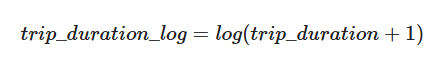

In [33]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

In [93]:
from scipy.stats import shapiro

stat, p_value = shapiro(taxi_data['trip_duration_log'])
print(f"Статистика теста: {stat}, p-value: {p_value}")

if p_value > 0.05:
    print("Распределение не отличается от нормального (принимаем H0).")
else:
    print("Распределение значительно отличается от нормального (отвергаем H0).")


Статистика теста: 0.9777677059173584, p-value: 0.0
Распределение значительно отличается от нормального (отвергаем H0).


#### Гистограмма длительности поездок в логарифмическом масштабе

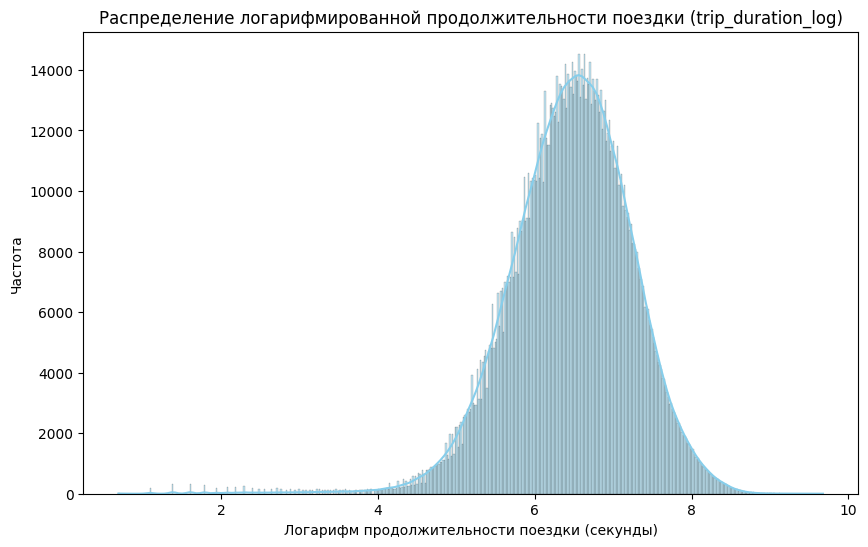

In [34]:
plt.figure(figsize=(10, 6))
sns.histplot(taxi_data['trip_duration_log'], kde=True, color='skyblue')
plt.title('Распределение логарифмированной продолжительности поездки (trip_duration_log)')
plt.xlabel('Логарифм продолжительности поездки (секунды)')
plt.ylabel('Частота')
plt.show()


##### Посмотрим на основные статистические характеристики для логарифмированной продолжительности поездки:

In [35]:

log_trip_duration_stats = taxi_data['trip_duration_log'].describe()
log_trip_duration_stats

count    1.456571e+06
mean     6.460089e+00
std      7.750084e-01
min      6.931472e-01
25%      5.986452e+00
50%      6.496775e+00
75%      6.979145e+00
max      9.674137e+00
Name: trip_duration_log, dtype: float64

##### Корреляция с другими признаками

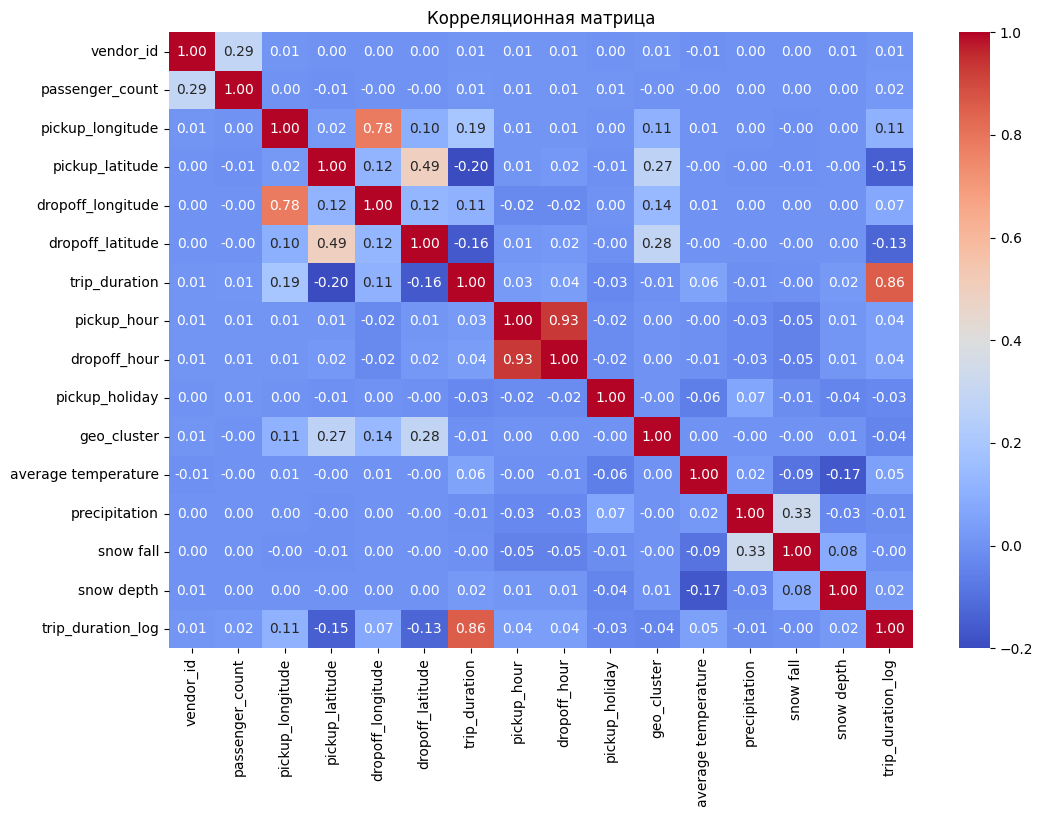

In [36]:
correlation_matrix = taxi_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционная матрица')
plt.show()


#### Распределение длительности поездки в логарифмическом масштабе в зависимости от таксопарка

In [37]:
taxi_data['vendor_id'].value_counts()

2    778238
1    678333
Name: vendor_id, dtype: int64

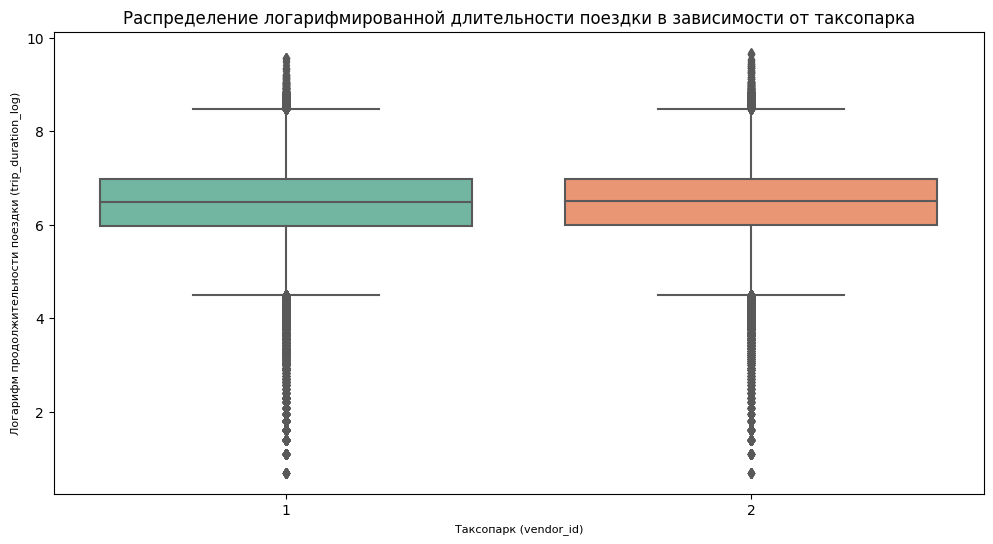

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))


sns.boxplot(data=taxi_data, x='vendor_id', y='trip_duration_log', palette='Set2')


plt.title('Распределение логарифмированной длительности поездки в зависимости от таксопарка', fontsize=12)
plt.xlabel('Таксопарк (vendor_id)', fontsize=8)
plt.ylabel('Логарифм продолжительности поездки (trip_duration_log)', fontsize=8)

# Покажем график
plt.show()


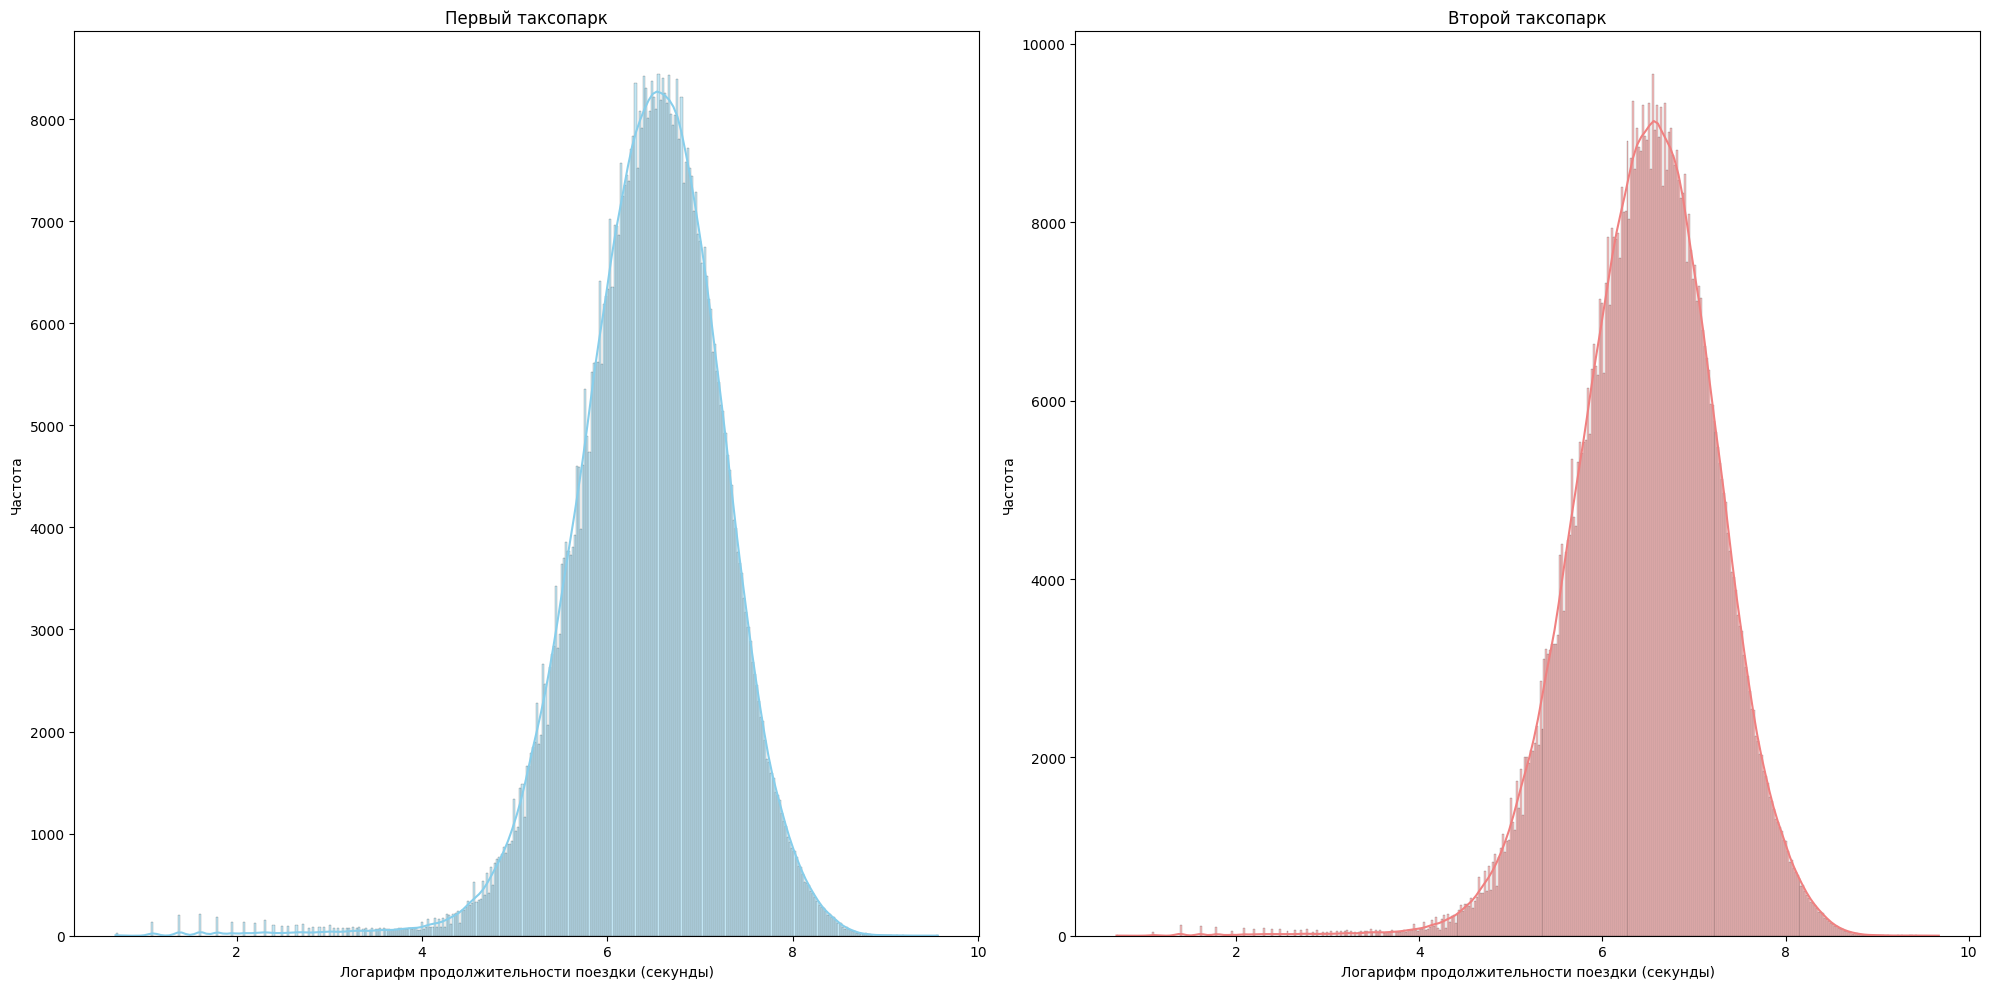

In [39]:
# Создаем фигуру с двумя подграфиками
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# Строим гистограмму для первого таксопарка
sns.histplot(data=taxi_data[taxi_data['vendor_id'] == 1]['trip_duration_log'], ax=axes[0], color='skyblue', kde=True)
axes[0].set_title('Первый таксопарк')
axes[0].set_xlabel('Логарифм продолжительности поездки (секунды)')
axes[0].set_ylabel('Частота')

# Строим гистограмму для второго таксопарка
sns.histplot(data=taxi_data[taxi_data['vendor_id'] == 2]['trip_duration_log'], ax=axes[1], color='lightcoral', kde=True)
axes[1].set_title('Второй таксопарк')
axes[1].set_xlabel('Логарифм продолжительности поездки (секунды)')
axes[1].set_ylabel('Частота')

# Показываем графики
plt.tight_layout()
plt.show()

Распределения длительности поездок в логарифмическом масштабе у таксопарков близки друг к другу

### Сравнение распределение поездки от признаки отправки сообщения

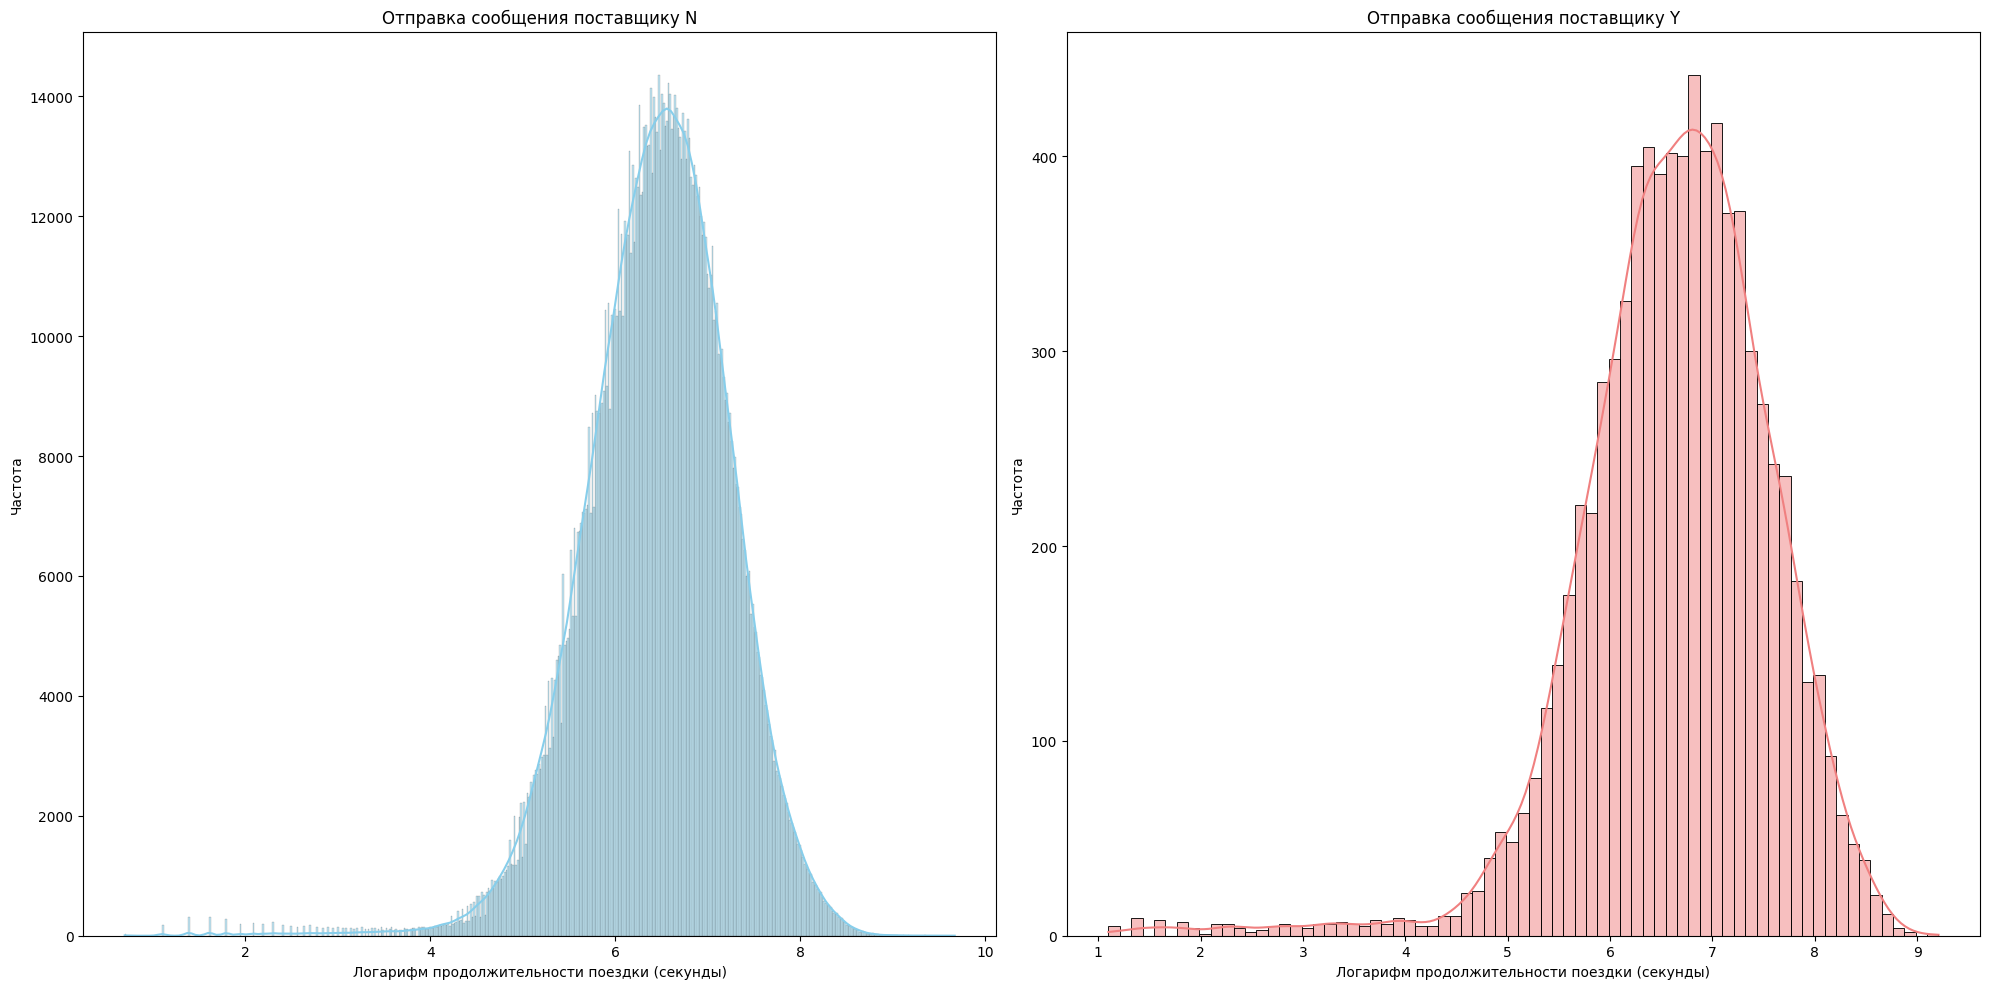

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

sns.histplot(data=taxi_data[taxi_data['store_and_fwd_flag'] == 'N']
             ['trip_duration_log'], ax=axes[0], color='skyblue', kde=True)
axes[0].set_title('Отправка сообщения поставщику N')
axes[0].set_xlabel('Логарифм продолжительности поездки (секунды)')
axes[0].set_ylabel('Частота')

sns.histplot(data=taxi_data[taxi_data['store_and_fwd_flag'] == 'Y']
             ['trip_duration_log'], ax=axes[1], color='lightcoral', kde=True)
axes[1].set_title('Отправка сообщения поставщику Y')
axes[1].set_xlabel('Логарифм продолжительности поездки (секунды)')
axes[1].set_ylabel('Частота')

plt.tight_layout()
plt.show()

 - Оба распределения имеют схожую форму, напоминающую нормальное распределение. Это говорит о том, что большинство поездок как с отправкой сообщения, так и без нее имеют примерно одинаковую продолжительность.  
 - Визуально кажется, что дисперсия (разброс данных) на правом графике может быть немного больше, чем на левом. Это может означать, что продолжительность поездок с отправкой сообщения чуть более более вариативна.

### Распределение количества поездок в зависимости от часа дня

In [41]:
data_count = taxi_data.groupby(by='pickup_hour', as_index=False)['trip_duration'].count()
data_median = taxi_data.groupby(by='pickup_hour', as_index=False)['trip_duration'].median()

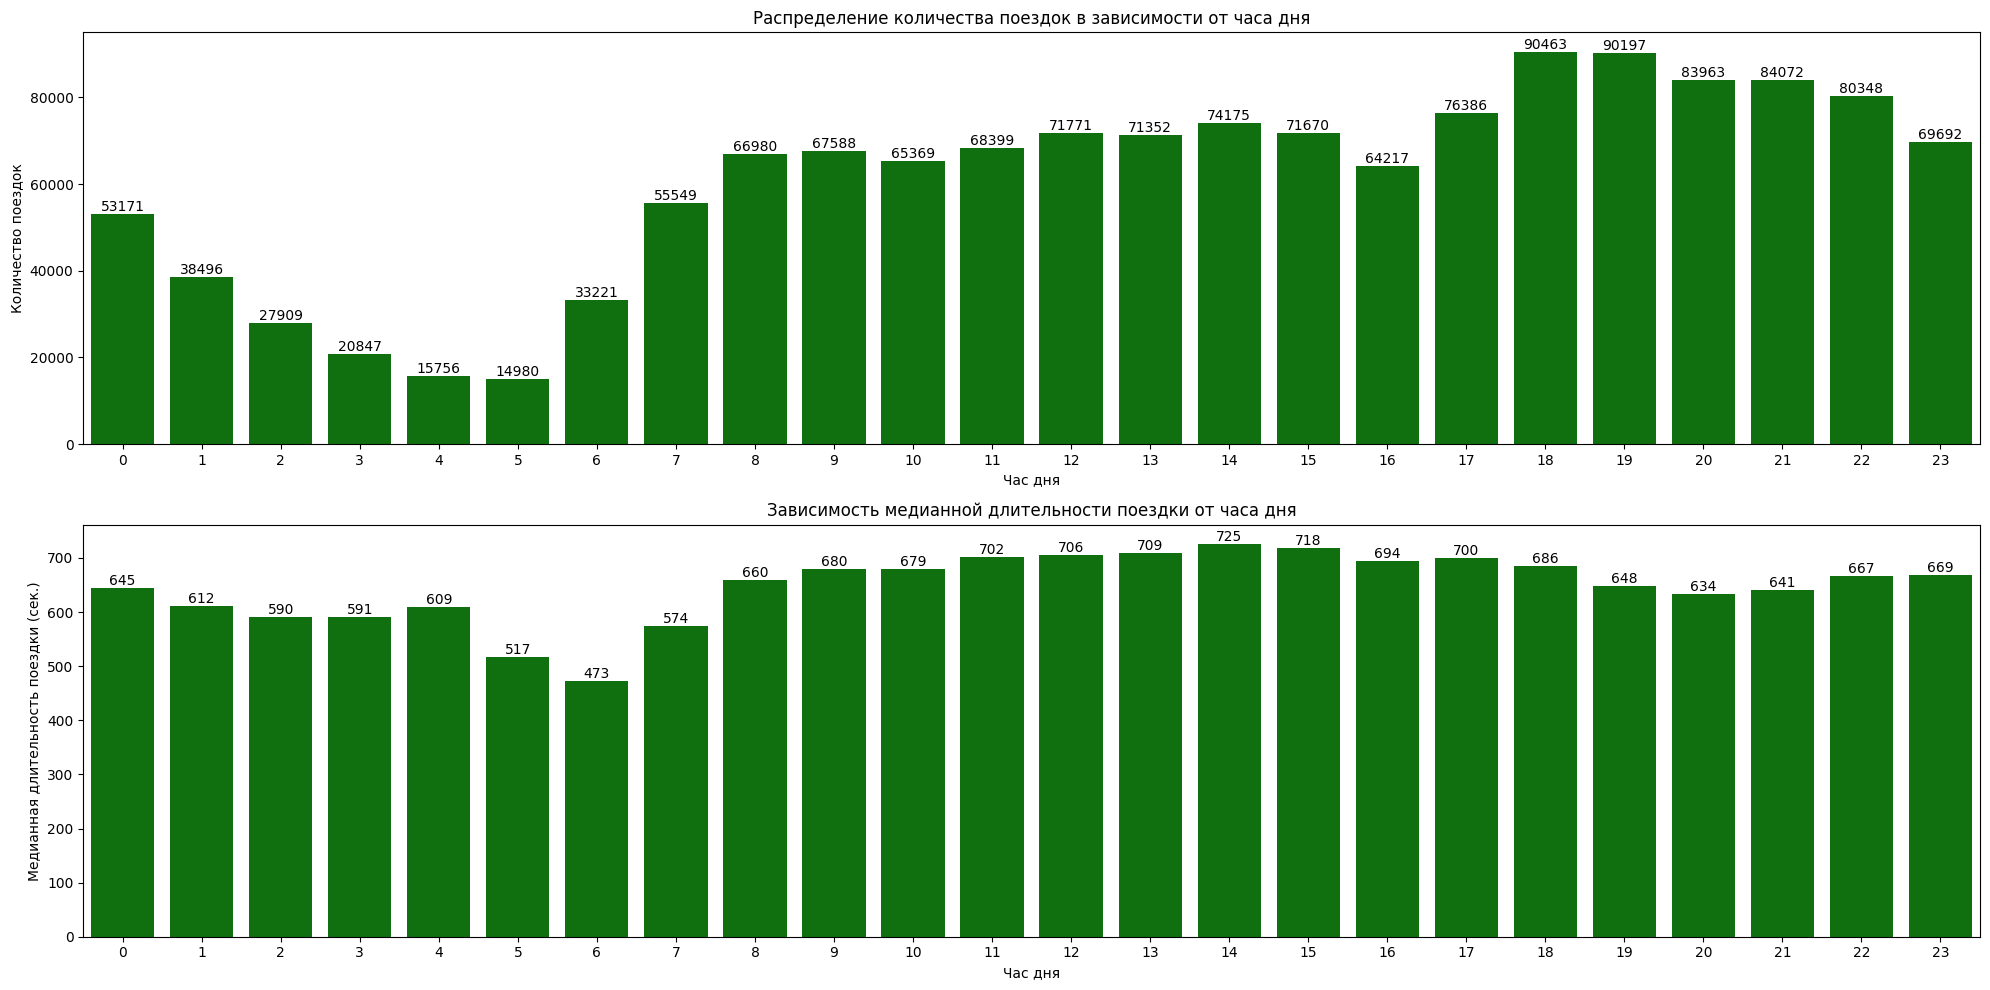

In [42]:

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))

# График количества поездок по часам дня
barplot = sns.barplot(
    data=data_count,
    x='pickup_hour',  
    y='trip_duration', 
    color='green',
    ax=axes[0]
)
barplot.set_title('Распределение количества поездок в зависимости от часа дня')
barplot.set_xlabel('Час дня')  
barplot.set_ylabel('Количество поездок')  
barplot.bar_label(barplot.containers[0])  

# График медианной длительности поездки по часам дня
barplot = sns.barplot(
    data=data_median,
    x='pickup_hour',  
    y='trip_duration',  
    color='green',
    ax=axes[1]
)
barplot.set_title('Зависимость медианной длительности поездки от часа дня')
barplot.set_xlabel('Час дня')  
barplot.set_ylabel('Медианная длительность поездки (сек.)')  
barplot.bar_label(barplot.containers[0])  

plt.tight_layout()
plt.show()


Вывод:  

- Наблюдается ярко выраженная пиковая активность в вечерние часы (18-21).  
- В ночные часы (с 0 до 5) количество поездок значительно снижается. В 5 часов утра наименьшее количество поездок
- Пик медианы наблюдается в 14 часов дня

### Распределение количества поездок в зависимости от дня недели

In [43]:
data_count_day_of_week = taxi_data.groupby(by='pickup_day_of_week', as_index=False)['trip_duration'].count()
data_mdeian_day_of_week = taxi_data.groupby(by='pickup_day_of_week', as_index=False)['trip_duration'].median()

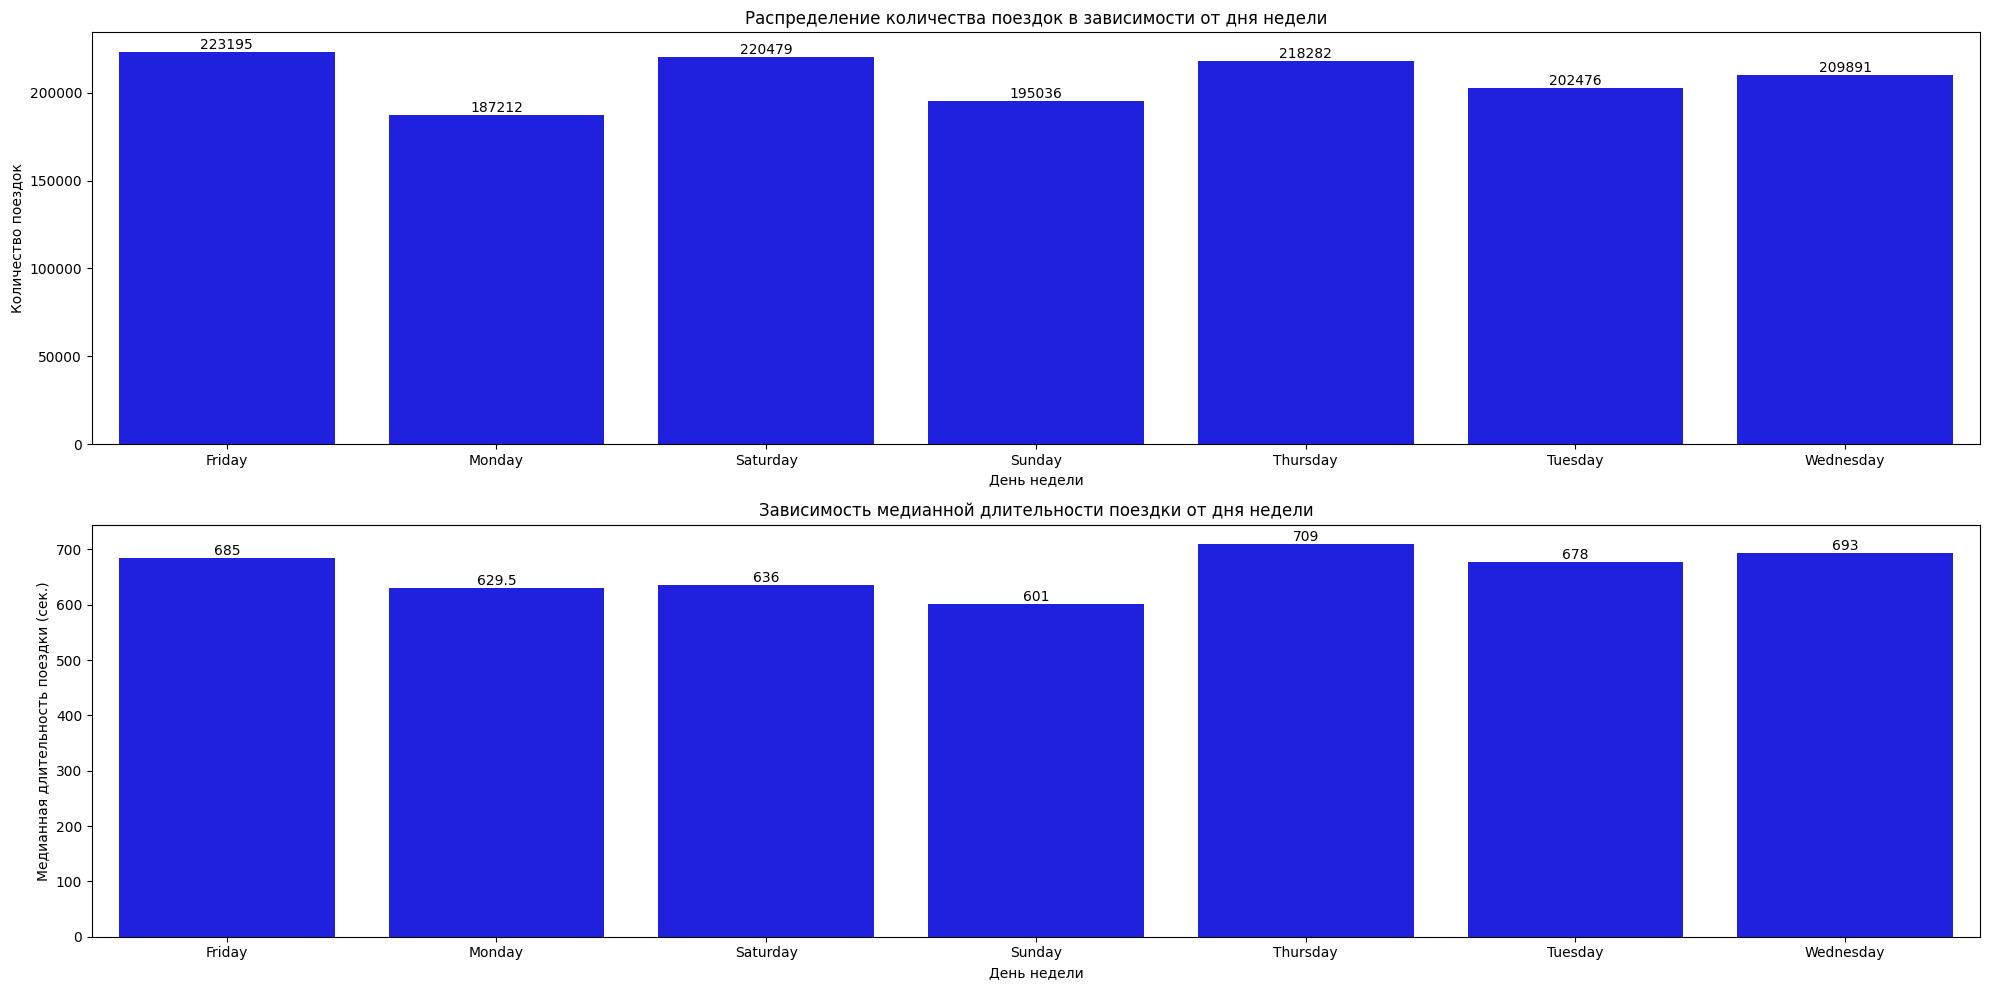

In [44]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))


barplot = sns.barplot(
    data=data_count_day_of_week,
    x='pickup_day_of_week',  
    y='trip_duration',  
    color='blue',
    ax=axes[0]
)
barplot.set_title('Распределение количества поездок в зависимости от дня недели')
barplot.set_xlabel('День недели')  
barplot.set_ylabel('Количество поездок')  
barplot.bar_label(barplot.containers[0])  

barplot = sns.barplot(
    data=data_mdeian_day_of_week,
    x='pickup_day_of_week',  
    y='trip_duration',  
    color='blue',
    ax=axes[1]
)
barplot.set_title('Зависимость медианной длительности поездки от дня недели')
barplot.set_xlabel('День недели') 
barplot.set_ylabel('Медианная длительность поездки (сек.)')  
barplot.bar_label(barplot.containers[0])  

plt.tight_layout() 
plt.show()

Вывод:  

- Наиболее загруженными днями являются пятница и суббота.  
- Медианная продолжительность поездок меняется в зависимости от дня недели, хотя различия не столь выражены, как в количестве поездок. 
- Наибольшая медианная продолжительность поездки наблюдается в четверг

### Сводная таблица и тепловая карта зависимости часа дня и дни недели

In [45]:
pivot = taxi_data.pivot_table(
    values='trip_duration',
    index='pickup_hour',
    columns='pickup_day_of_week',
    fill_value=0,
    aggfunc='median'
)
pivot

pickup_day_of_week  Friday  Monday  Saturday  Sunday  Thursday  Tuesday  \
pickup_hour                                                               
0                    648.0   596.0     683.0   675.0     608.0    590.0   
1                    600.0   566.5     639.0   642.0     564.0    584.0   
2                    571.0   562.0     608.0   604.0     575.5    564.0   
3                    576.0   599.0     589.0   607.0     583.0    568.0   
4                    633.0   638.0     606.5   597.0     595.0    598.0   
5                    530.0   518.0     629.0   632.0     477.0    454.0   
6                    476.0   462.0     507.5   553.0     471.0    460.5   
7                    578.0   575.0     481.0   472.5     599.0    585.0   
8                    689.0   671.0     489.0   459.0     719.5    703.0   
9                    741.0   704.0     509.0   469.0     772.0    754.0   
10                   744.0   693.0     542.0   505.0     771.0    776.5   
11                   754.0   701.0     579.0   550.0     801.0    805.0   
12                   744.5   691.5     618.0   593.0     797.0    782.0   
13                   711.0   672.0     650.0   627.0     771.0    767.0   
14                   734.0   680.0     658.0   666.0     810.0    768.0   
15                   757.0   675.0     660.0   657.0     784.0    739.0   
16                   728.0   639.0     654.0   672.0     755.0    704.0   
17                   711.0   643.0     684.0   649.0     752.0    712.0   
18                   695.0   636.0     677.0   640.0     728.0    699.0   
19                   668.0   575.0     697.0   600.0     691.0    631.0   
20                   663.0   572.5     668.0   583.5     681.5    621.0   
21                   665.0   596.0     655.0   570.0     692.0    633.0   
22                   705.0   601.0     688.0   584.0     707.0    658.0   
23                   716.0   611.0     703.0   595.0     691.0    631.0   

pickup_day_of_week  Wednesday  
pickup_hour                    
0                       599.0  
1                       552.0  
2                       543.0  
3                       572.0  
4                       615.0  
5                       447.0  
6                       462.5  
7                       592.0  
8                       703.0  
9                       741.0  
10                      787.0  
11                      808.0  
12                      799.0  
13                      796.0  
14                      781.0  
15                      771.0  
16                      740.0  
17                      758.0  
18                      723.0  
19                      658.0  
20                      638.0  
21                      664.0  
22                      674.0  
23                      657.0

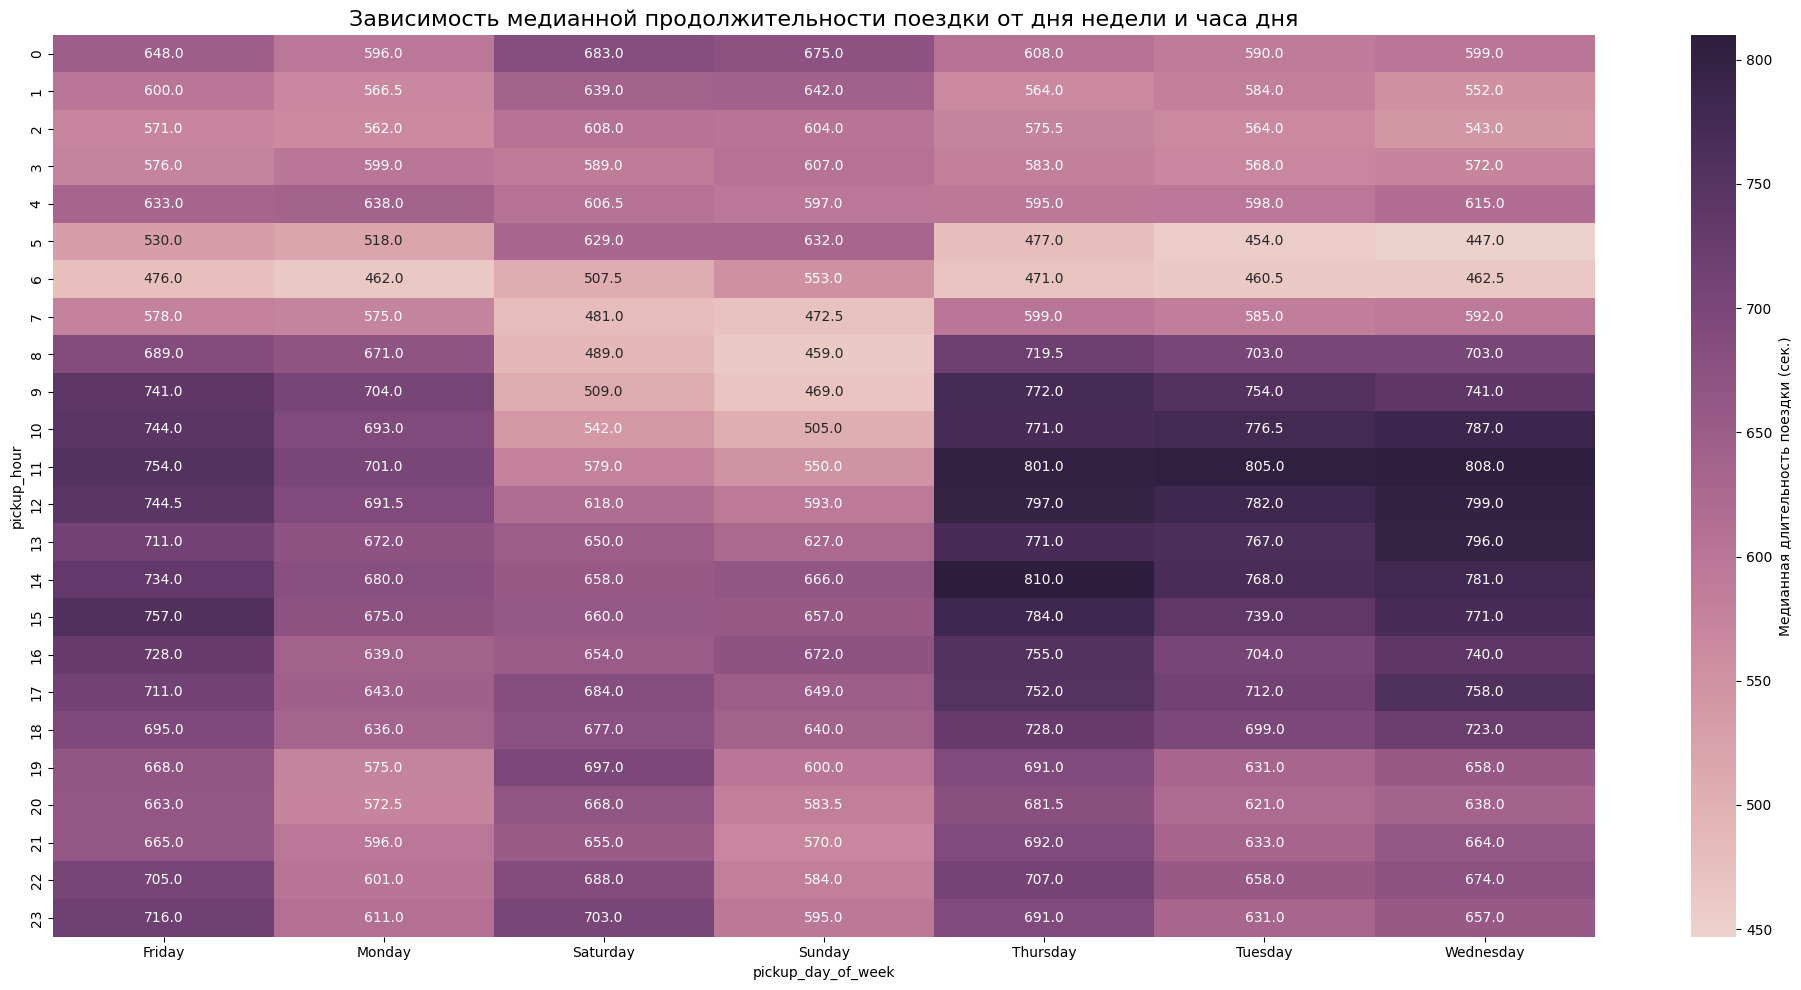

In [46]:
fig, axes = plt.subplots(figsize=(20, 10))  
pivot_time = sns.heatmap(
    data=pivot,
    cmap=sns.cubehelix_palette(as_cmap=True), 
    annot=True, 
    fmt='.1f',  
    cbar_kws={'label': 'Медианная длительность поездки (сек.)'},  
    ax=axes  
)

pivot_time.set_title('Зависимость медианной продолжительности поездки от дня недели и часа дня', fontsize=16)

plt.tight_layout()  
plt.show()

### Географическое расположение точек начала и конец поездок

In [47]:
taxi_data['pickup_latitude'].min(), taxi_data['pickup_latitude'].max()


(34.35969543457031, 51.88108444213867)

Первая диаграмма будет иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude)  
Вторая - географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).  

Будем включать в визуализацию только точки, которые находятся в пределах Нью-Йорка

city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)  

Также на в визуализации отметим точки по 10ти кластерам, которые рассчитывали ранее

In [48]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

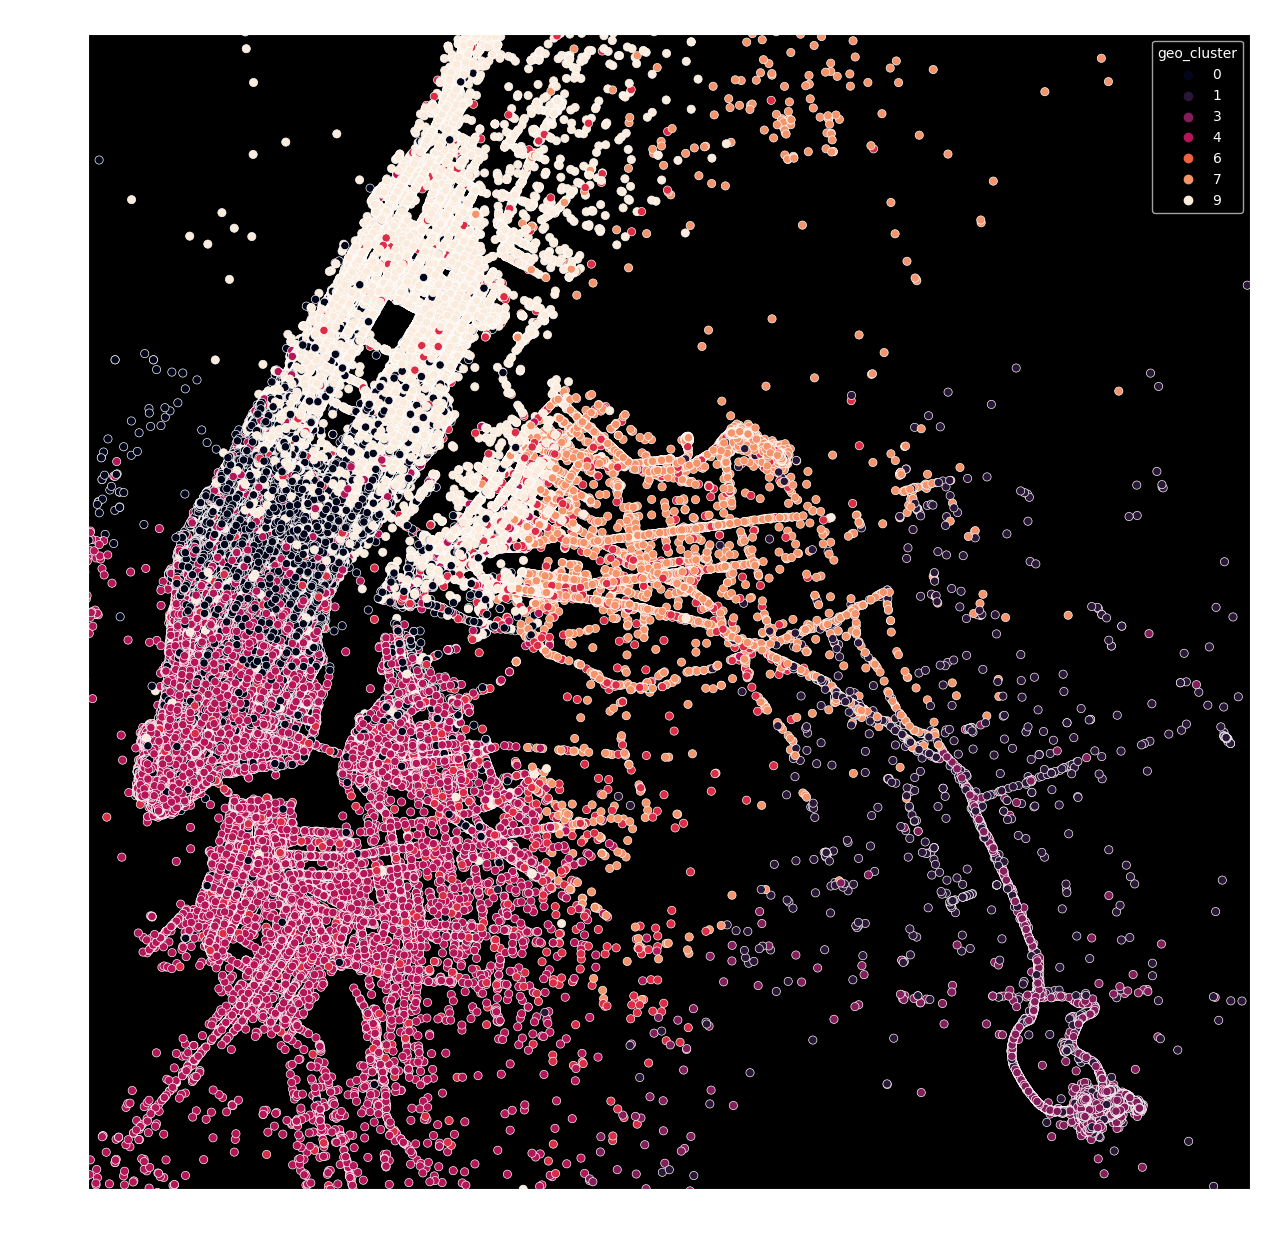

In [49]:
fig = plt.figure(figsize=(15, 15))
plt.style.use('dark_background')
scatterplot2 = sns.scatterplot(
    data=taxi_data,
    x='pickup_longitude',
    y='pickup_latitude',
    hue='geo_cluster',
    palette='rocket',
    s=35
)
scatterplot2.set(xlim=city_long_border, ylim=city_lat_border)
scatterplot2.set_title('Географическое расположение точек начала поездок', fontsize=16)
scatterplot2.set_xlabel('Широта')
scatterplot2.set_ylabel('Долгота')

plt.show()

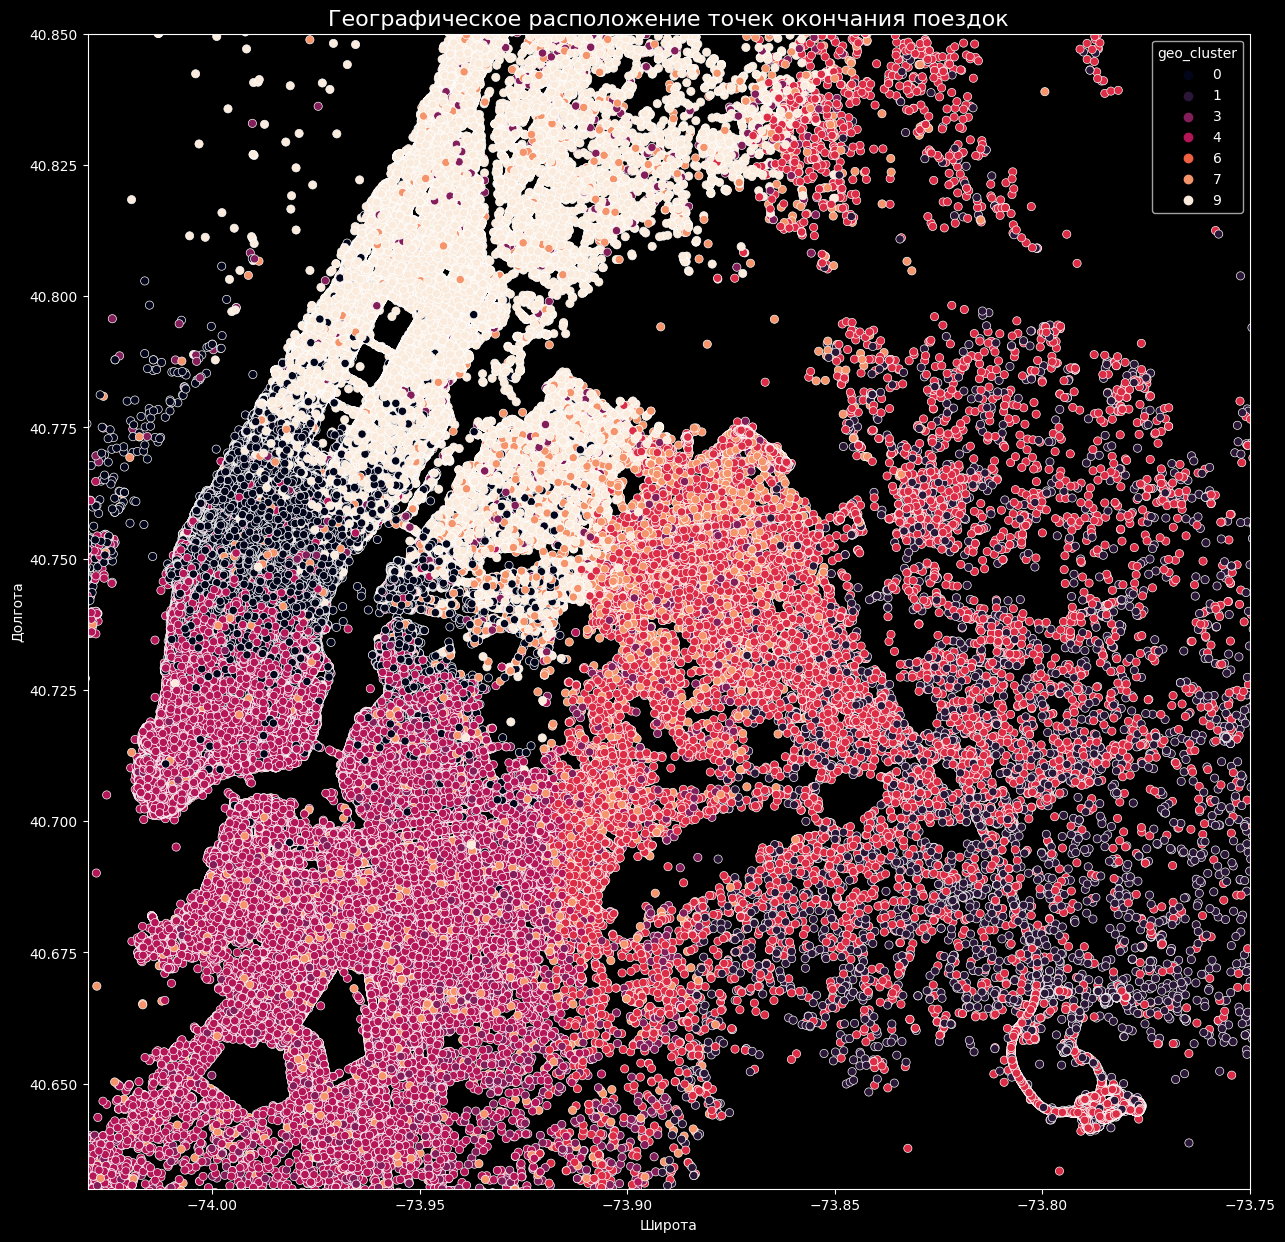

In [50]:
fig = plt.figure(figsize=(15, 15))
plt.style.use('dark_background')
scatterplot2 = sns.scatterplot(
    data=taxi_data,
    x='dropoff_longitude',
    y='dropoff_latitude',
    hue='geo_cluster',
    palette='rocket',
    s=35
)
scatterplot2.set(xlim=city_long_border, ylim=city_lat_border)
scatterplot2.set_title('Географическое расположение точек окончания поездок', fontsize=16)
scatterplot2.set_xlabel('Широта')
scatterplot2.set_ylabel('Долгота')

plt.show()

## Отбор и преобразование признаков

In [51]:
taxi_data.shape

(1456571, 24)

для удобства работы создам копию текущего датафрейма

In [52]:
df_train = taxi_data.copy()
df_train.head()

id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:55 2016-03-14 17:32:30   
1  id2377394          1 2016-06-12 00:43:35 2016-06-12 00:54:38   
2  id3858529          2 2016-01-19 11:35:24 2016-01-19 12:10:48   
3  id3504673          2 2016-04-06 19:32:31 2016-04-06 19:39:40   
4  id2181028          2 2016-03-26 13:30:55 2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  ...  dropoff_date dropoff_hour  \
0         40.765602                  N  ...    2016-03-14           17   
1         40.731152                  N  ...    2016-06-12            0   
2         40.710087                  N  ...    2016-01-19           12   
3         40.706718                  N  ...    2016-04-06           19   
4         40.782520                  N  ...    2016-03-26           13   

   dropoff_day_of_week pickup_holiday geo_cluster  average temperature  \
0               Monday              0           9                 45.5   
1               Sunday              0           4                 72.5   
2              Tuesday              0           4                 22.0   
3            Wednesday              0           4                 39.0   
4             Saturday              0           9                 46.5   

  precipitation  snow fall  snow depth  trip_duration_log  
0          0.29        0.0           0           6.122493  
1          0.00        0.0           0           6.498282  
2          0.00        0.0           0           7.661527  
3          0.00        0.0           0           6.063785  
4          0.00        0.0           0           6.077642  

[5 rows x 24 columns]

##### Убираем ненужные столбцы

In [ ]:
drop_columns = ['pickup_datetime', 'pickup_date','dropoff_date', 'id', 'dropoff_datetime']
train_data = df_train.drop(drop_columns, axis=1)
print(f'Размеры данных:  {train_data.shape}')

Размеры данных:  (1456571, 19)


##### Кодировка признака vendor_id и store_and_fwd_flag

In [54]:
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)

In [55]:
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)

In [56]:
train_data.dtypes

vendor_id                int64
passenger_count          int64
pickup_longitude       float64
pickup_latitude        float64
dropoff_longitude      float64
dropoff_latitude       float64
store_and_fwd_flag       int64
trip_duration            int64
pickup_hour              int64
pickup_day_of_week      object
dropoff_hour             int64
dropoff_day_of_week     object
pickup_holiday           int64
geo_cluster              int32
average temperature    float64
precipitation          float64
snow fall              float64
snow depth               int32
trip_duration_log      float64
dtype: object

##### Применим OneHotEncoder для категориальных признаков

In [57]:
columns_to_change = ['pickup_day_of_week', 'geo_cluster', 'dropoff_day_of_week']
encoder = preprocessing.OneHotEncoder(drop='first')
data_onehot = encoder.fit_transform(train_data[['pickup_day_of_week', 'geo_cluster','dropoff_day_of_week']]).toarray()


column_names = encoder.get_feature_names_out(columns_to_change)
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
print(f'Получилось сгенерировать с помощью однократного кодирования {len(data_onehot.axes[1])} бинарных столбцов')

Получилось сгенерировать с помощью однократного кодирования 21 бинарных столбцов


##### Добавим полученную таблицу с закодированными признаками:

In [58]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_change, axis=1), data_onehot], 
    axis=1
)
print(f'Размер данных: {train_data.shape}')

Размер данных: (1456571, 37)


In [59]:
train_data.columns

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_hour', 'dropoff_hour', 'pickup_holiday',
       'average temperature', 'precipitation', 'snow fall', 'snow depth',
       'trip_duration_log', 'pickup_day_of_week_Monday',
       'pickup_day_of_week_Saturday', 'pickup_day_of_week_Sunday',
       'pickup_day_of_week_Thursday', 'pickup_day_of_week_Tuesday',
       'pickup_day_of_week_Wednesday', 'geo_cluster_1', 'geo_cluster_2',
       'geo_cluster_3', 'geo_cluster_4', 'geo_cluster_5', 'geo_cluster_6',
       'geo_cluster_7', 'geo_cluster_8', 'geo_cluster_9',
       'dropoff_day_of_week_Monday', 'dropoff_day_of_week_Saturday',
       'dropoff_day_of_week_Sunday', 'dropoff_day_of_week_Thursday',
       'dropoff_day_of_week_Tuesday', 'dropoff_day_of_week_Wednesday'],
      dtype='object')

In [60]:
train_data.dtypes

vendor_id                          int64
passenger_count                    int64
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
store_and_fwd_flag                 int64
trip_duration                      int64
pickup_hour                        int64
dropoff_hour                       int64
pickup_holiday                     int64
average temperature              float64
precipitation                    float64
snow fall                        float64
snow depth                         int32
trip_duration_log                float64
pickup_day_of_week_Monday        float64
pickup_day_of_week_Saturday      float64
pickup_day_of_week_Sunday        float64
pickup_day_of_week_Thursday      float64
pickup_day_of_week_Tuesday       float64
pickup_day_of_week_Wednesday     float64
geo_cluster_1                    float64
geo_cluster_2                    float64
geo_cluster_3   

##### Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:

In [61]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log.

In [62]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

In [63]:
print(f"Размер тренировочной выборки: {X_train.shape[0]} примеров")
print(f"Размер валидационной выборки: {X_valid.shape[0]} примеров")

Размер тренировочной выборки: 975902 примеров
Размер валидационной выборки: 480669 примеров


На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.

### Отбор наилучших 25 признаков

In [64]:
def select_top_k_features(X_train, y_train_log, k=25):

    selector = feature_selection.SelectKBest(feature_selection.f_regression, k=k)
    selector.fit(X_train, y_train_log)
    
    best_features = selector.get_feature_names_out()
    
    return X_train[best_features], best_features

# Выбираем 25 лучших признаков
X_train, best_features = select_top_k_features(X_train, y_train_log, k=25)
X_valid = X_valid[best_features]

X_train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 975902 entries, 208808 to 121958
Data columns (total 25 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   passenger_count                975902 non-null  int64  
 1   pickup_longitude               975902 non-null  float64
 2   pickup_latitude                975902 non-null  float64
 3   dropoff_longitude              975902 non-null  float64
 4   dropoff_latitude               975902 non-null  float64
 5   store_and_fwd_flag             975902 non-null  int64  
 6   pickup_hour                    975902 non-null  int64  
 7   dropoff_hour                   975902 non-null  int64  
 8   pickup_holiday                 975902 non-null  int64  
 9   average temperature            975902 non-null  float64
 10  snow depth                     975902 non-null  int32  
 11  pickup_day_of_week_Monday      975902 non-null  float64
 12  pickup_day_of_week_Saturd

### Нормализация 

In [65]:
def normalize_features(X_train, X_valid):
    scaler = StandardScaler()
    
    X_train_scaled = scaler.fit_transform(X_train)
    
    X_valid_scaled = scaler.transform(X_valid)
    
    return pd.DataFrame(X_train_scaled, columns=X_train.columns), pd.DataFrame(X_valid_scaled, columns=X_valid.columns)

X_train_scaled, X_valid_scaled = normalize_features(X_train, X_valid)

X_train_scaled.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975902 entries, 0 to 975901
Data columns (total 25 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   passenger_count                975902 non-null  float64
 1   pickup_longitude               975902 non-null  float64
 2   pickup_latitude                975902 non-null  float64
 3   dropoff_longitude              975902 non-null  float64
 4   dropoff_latitude               975902 non-null  float64
 5   store_and_fwd_flag             975902 non-null  float64
 6   pickup_hour                    975902 non-null  float64
 7   dropoff_hour                   975902 non-null  float64
 8   pickup_holiday                 975902 non-null  float64
 9   average temperature            975902 non-null  float64
 10  snow depth                     975902 non-null  float64
 11  pickup_day_of_week_Monday      975902 non-null  float64
 12  pickup_day_of_week_Saturday   

## Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:

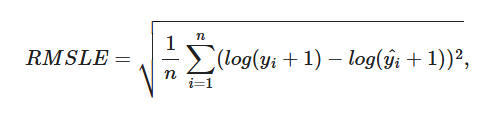

где:

 - истинная длительность i-ой поездки на такси (trip_duration)
- предсказанная моделью длительность i-ой поездки на такси
Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:


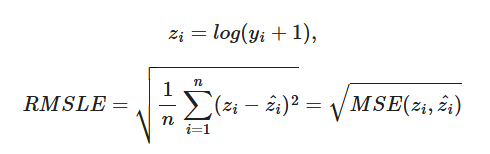

### Модель линейной регрессии

In [80]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [82]:
lr_model = linear_model.LinearRegression()
lr_model.fit(X_train_scaled, y_train_log)

y_pred_lr = lr_model.predict(X_valid_scaled)

rmsle_lr = np.sqrt(mean_squared_error(y_valid_log, y_pred_lr))
mae_lr = mean_absolute_error(y_valid_log, y_pred_lr)

r2_lr = r2_score(y_valid_log, y_pred_lr)

print(f"Линейная регрессия - RMSLE: {rmsle_lr}, MAE: {mae_lr}, R²: {r2_lr}")

Линейная регрессия - RMSLE: 0.7049697458622245, MAE: 0.5387495594002132, R²: 0.1716501622051546


### Модель полиномиальной регрессии 2-ой степени

In [69]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [83]:
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_scaled)
X_valid_poly = poly.transform(X_valid_scaled)

poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train_log)

y_pred_poly = poly_model.predict(X_valid_poly)

# Вычисление метрик
rmsle_poly = np.sqrt(mean_squared_error(y_valid_log, y_pred_poly))
mae_poly = mean_absolute_error(y_valid_log, y_pred_poly)
r2_poly = r2_score(y_valid_log, y_pred_poly)

print(f"Полинномиальнаяа регрессия - RMSLE: {rmsle_poly}, MAE: {mae_poly}, R²: {r2_poly}")


Полинномиальнаяа регрессия - RMSLE: 0.6513938983427515, MAE: 0.4910391610819367, R²: 0.292770764865914


### Модель дерева решений

In [71]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [84]:
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_true + 1) - np.log1p(y_pred + 1))))

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

dt_model = DecisionTreeRegressor(random_state=42)

param_grid_dt = {
    'max_depth': [5, 10, 15, 19],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

grid_search_dt = GridSearchCV(estimator=dt_model, param_grid=param_grid_dt, cv=3, n_jobs=-1, verbose=1, scoring=rmsle_scorer)

grid_search_dt.fit(X_train_scaled, y_train_log)

best_dt_model = grid_search_dt.best_estimator_


y_pred_dt = best_dt_model.predict(X_valid_scaled)

rmsle_dt = np.sqrt(mean_squared_error(y_valid_log, y_pred_dt))
mae_dt = mean_absolute_error(y_valid_log, y_pred_dt)
r2_dt = r2_score(y_valid_log, y_pred_dt)

print(f"Дерево решений - RMSLE: {rmsle_dt}, MAE: {mae_dt}, R²: {r2_dt}")


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Дерево решений - RMSLE: 0.4814412579566399, MAE: 0.33803623623956736, R²: 0.6136691024832233


### Модель случайного леса

In [74]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [85]:
rf_model = RandomForestRegressor(random_state=42)


rf_model.fit(X_train_scaled, y_train_log)


y_pred_rf = rf_model.predict(X_valid_scaled)

rmsle_rf = np.sqrt(mean_squared_error(y_valid_log, y_pred_rf))
mae_rf = mean_absolute_error(y_valid_log, y_pred_rf)

r2_rf = r2_score(y_valid_log, y_pred_rf)

print(f"Случайный лес - RMSLE: {rmsle_rf}, MAE: {mae_rf}, R²: {r2_rf}")

Случайный лес - RMSLE: 0.3651873279918452, MAE: 0.24572036023785213, R²: 0.7777180331875045


### Модель градиентного бустинга

In [77]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:

gb_model = GradientBoostingRegressor(random_state=42)

gb_model.fit(X_train_scaled, y_train_log)

y_pred_gb = gb_model.predict(X_valid_scaled)


rmsle_gb = np.sqrt(np.mean((y_valid_log - y_pred_gb) ** 2))

mae_gb = mean_absolute_error(y_valid_log, y_pred_gb)

r2_gb = r2_score(y_valid_log, y_pred_gb)

print(
    f"Градиентный бустинг - RMSLE: {rmsle_gb}, MAE: {mae_gb}, R²: {r2_gb}")

Градиентный бустинг - RMSLE: 0.5747979647500439, MAE: 0.42425480605240556, R²: 0.44931496305311325


### Выбор модели  

Наименьшая ошибка RMSLE на валидационной выборке оказалась на модели градиентного бустинга. Поэтому выберем эту модель

### Диаграмма коэффициентов

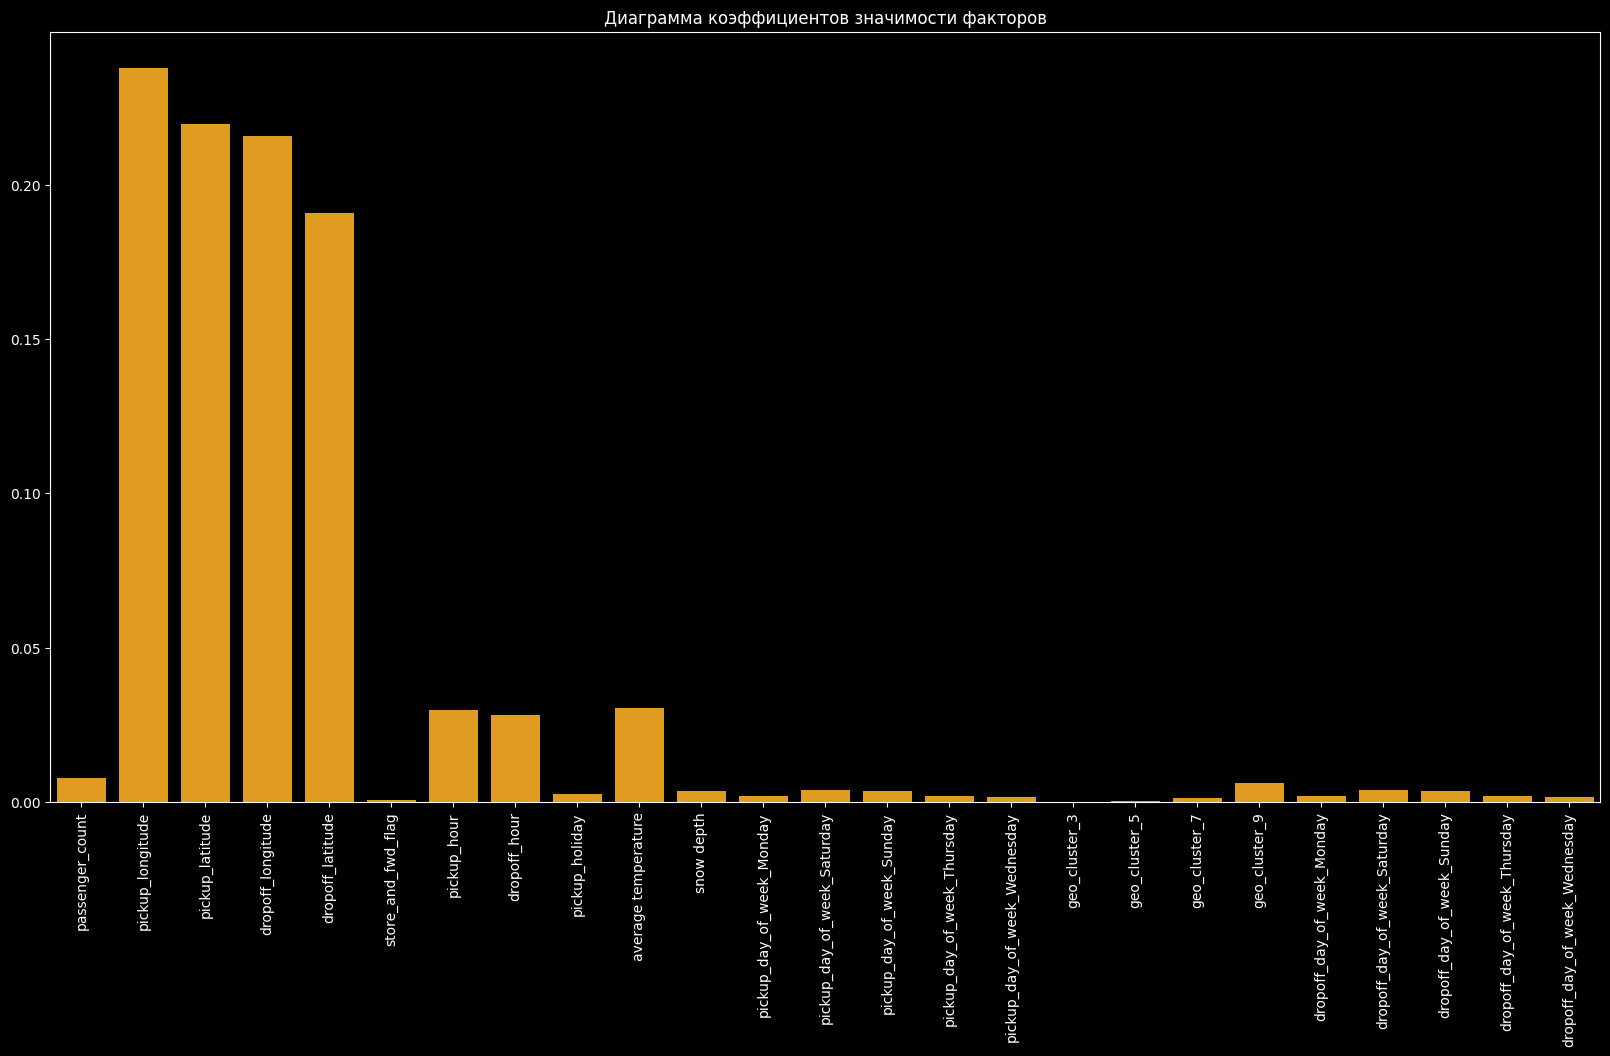

In [94]:
coef = rf_model.feature_importances_
data = pd.DataFrame([coef], columns=best_features)
fig = plt.figure(figsize=(20, 10))
barplot = sns.barplot(
    data=data,color="orange")
barplot.set_title('Диаграмма коэффициентов значимости факторов')
barplot.set_xticklabels(barplot.get_xticklabels(),rotation = 90)

plt.show()

Видим, что наиболее значимыми переменными являются pickup_longitude, pickup_latitude, dropoff_latitde, dropoff_longitude. 